# [SC57 - Working with big, multi-dimensional geoscientific datasets in Python: a tutorial introduction to xarray](http://meetingorganizer.copernicus.org/EGU2017/session/25651)  
  
  
* Original notebook by [Stephan Hoyer](http://stephanhoyer.com), Rossbypalooza, 2016.  
* Modified by Edward Byers, Matthew Gidden and [Fabien Maussion](http://fabienmaussion.info/) for EGU General Assembly 2017, Vienna, Austria
* Modified by C. Gentemann for GHRSST Science Team Tutorial 2019, Rome, Italy
* Modified by C. Gentemann for OceanHackWeek 2019, Seattle, WA
* PODAACPY file search added by Lewis John McGibbney
  

# Structure of this tutorial

1. Searching for data at NASA's PODAAC
1. Opening data
1. Data plotting, exploration, subsetting
1. Comparing two datasets
1. Comparing timeseries of data


# 1. Key features of `xarray`

*  `xarray` is an open source project and Python package
*  `xarray` has been designed to perform **labelled** data analysis on **multi-dimensional** arrays
* the `xarray` approach adopts the Common Data Model for **self-describing scientific data** in widespread use in the Earth sciences
*  `xarray.Dataset` is an in-memory representation of a netCDF file.
* `xarray` is built on top of the dataprocessing library [Pandas](http://pandas.pydata.org) (the best way to work with tabular data (e.g., CSV files) in Python)

# Our data

- numeric
- multi-dimensional
- labelled
- (lots of) metadata
- sometimes (very) large

## What is `xarray` good for?
* Gridded, multi-dimensional and large datasets, commonly used in earth sciences, but also increasingly finance, engineering (signal/image processing), and biological sciences
* Integration with other data analysis packages such as Pandas 
* I/O operations (NetCDF)
* Plotting
* Out of core computation and parallel processing
* ...

# 2. Basic operations in `xarray`

-------------------

## Import python packages

You are going to want numpy, pandas, matplotlib.pyplot, podaaacpy, and xarray

In [1]:
import warnings
warnings.simplefilter('ignore') # filter some warning messages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

from pathlib import Path
import configparser
from lxml import objectify

#for search capabilites import podaacpy
import podaac.podaac as podaac
from podaac import drive as podaacdrive
import podaac.podaac_utils as putil
# then create an instance of the Podaac class
p = podaac.Podaac()
with open('./podaac.ini', 'r') as f:
    config = configparser.ConfigParser()
    config.read_file(f)
    d = podaacdrive.Drive(None, 
                          config['drive']['urs_username'], 
                          config['drive']['urs_password'])

## Analysis of SSTs during Hurricane Irene

Irene was a massive storm, with tropical storm force winds extending outward 300 miles (485 km). The storm was also slow moving as it traversed the Mid-Atlantic. Irene claimed at least 48 lives and caused over 7 billion U.S. dollars in damages in the U.S. and 3.1 billion U.S. dollars of damage in the Caribbean. (source: https://www.ncdc.noaa.gov/sotc/tropical-cyclones/201113).

For this tutorial we will use the podaacpy to search for SST2 during Hurricane Irene and look at the change in upper ocean heat content

In [2]:
dataset_id_mur = 'PODAAC-GHCMC-4FM02'
#dataset_id_mur = 'PODAAC-GHCMC-4FM03'  #CMC SST looked up on podaac website
#dataset_id_mur = 'PODAAC-GHGMR-4FJ04'  #MUR SST looked up on podaac website
#dataset_id_mur = 'PODAAC-GHGDM-4FD02'  #DMI
dataset_id_ostia = 'PODAAC-GHOST-4FK01' #ostia sst

start_time = '2011-08-24T00:00:00Z'
end_time = '2011-09-01T23:59:59Z'
gresult = p.granule_search(dataset_id=dataset_id_mur,
                           start_time=start_time,
                           end_time=end_time,
                           items_per_page='100')
urls = putil.PodaacUtils.mine_opendap_urls_from_granule_search(gresult)
urls_mur = [w[:-5] for w in urls]  #remove html from urlsurls_sst = [w.replace('-tools.jpl.nasa.gov/drive/files/', '-opendap.jpl.nasa.gov/opendap/') for w in urls_sst]
print('num files:',len(urls_mur))
gresult = p.granule_search(dataset_id=dataset_id_ostia,
                           start_time=start_time,
                           end_time=end_time,
                           items_per_page='100')
urls = putil.PodaacUtils.mine_opendap_urls_from_granule_search(gresult)
urls_ostia = [w[:-5] for w in urls]  #remove html from urlsurls_sst = [w.replace('-tools.jpl.nasa.gov/drive/files/', '-opendap.jpl.nasa.gov/opendap/') for w in urls_sst]
print('num files:',len(urls_ostia))


num files: 10
num files: 10


We'll start with the MUR SST dataset. Other tutorial examples [here](https://github.com/pydata/xarray/tree/master/examples).

## 2. Examining your data

* With well designed mdatasets that follow Climate Forecast (CF) conventions, you will usually get coordinates of lat,lon,time which makes it easy to select data and visualize it in different ways.  

* Notice that the time is automatically converted into a np.datetime64 format which can be queried for month, day, etc.  All the variables that are CF compliant are automatically converted (if needed) and read in so that you can immediately start working with the data.  

* Above, you can see that the dimensions are lat, lon, and time

* The coordinates of the datasets are also lat,lon, and time


use [xr.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) to open the provided url and print the dataset

* url is a text string to an online dataset.  When you open a file, you can just use the file name and path or you can just use the url for files that are available online.  If you are running this on the cloud you could even call cloud located data

* Here, we are reading in a global SST dataset called CMC from NASA's PO.DAAC
   

## Open a SST dataset using the filename retrieved by podaacpy
Below, let's open MUR SSTs using xarray and a PODAAC OpenDAP URL.
To open a file use [xr.open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)

The url filename we want to use is already included for you.  You can give a local filename or an opendap URL.

Then just print out the file details by just typing the dataset name, ds_sst_mur

## Metadata --- Examining your data


* The data variable (analysed_sst) has the labeled dimensions and metadata attached.  You can see additional metadata (if it exists) by looking at the data variable of interest.  

* Below, type 
```ds_sst_mur.ana``` then hit tab to autocomplete.  
* Then run the cell by holding shift and pressing enter.



## Open & Subset the data using .sel to the North Atlantic region using slice

In [3]:
ds_sst = xr.open_dataset(urls_mur[0])
subset_sst = ds_sst.sel(lat=slice(15,45),lon=slice(-100,-40))
print('opening:', urls_mur[0],subset_sst)
#subset_sst.analysed_sst.plot()

opening: https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/CMC/CMC0.2deg/v2/2011/235/20110823120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc <xarray.Dataset>
Dimensions:           (lat: 151, lon: 301, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2011-08-23T12:00:00
  * lat               (lat) float32 15.0 15.2 15.4 15.6 ... 44.4 44.6 44.8 45.0
  * lon               (lon) float32 -100.0 -99.8 -99.6 ... -40.4 -40.2 -40.0
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.4
    title:                      CMC 0.2 deg global sea surface temperature an...
    summary:                    Applies the method of statistical interpolati...
    references:                 Brasnett B. 2008. The impact of satellite ret...
    

## Plot the SST.  
### Notice xarray adds labels and title to the plot and colorbar.  

Sometimes the metadata is great and you get exactly the label you need, but sometimes you want to change the label.  Xarray plotting [help](http://xarray.pydata.org/en/stable/plotting.html). A really nice feature of xarray is that it uses the metadata to label the axis.  Let's change the colorbar label by changing the `long_name` attribute

In [4]:
subset_sst.time

<xarray.DataArray 'time' (time: 1)>
array(['2011-08-23T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2011-08-23T12:00:00
Attributes:
    long_name:      reference time of sst field
    standard_name:  time
    comment:        
    axis:           T

In [5]:
#print out the attributes for `analysed_sst`
print(subset_sst.analysed_sst.attrs)

OrderedDict([('long_name', 'analysed sea surface temperature'), ('standard_name', 'sea_surface_foundation_temperature'), ('units', 'kelvin'), ('valid_min', -200), ('valid_max', 4000), ('source', 'EUR-L2P-ATS_NR_2P,REMSS_GRIDDED_25-AMSRE,NAVO-L2P-AVHRR18_G,NAVO-L2P-AVHRRMTA_G,NAVO-L2P-AVHRR19_G,REMSS-WINDSAT,IN_SITU-GTS_BUOYS,IN_SITU-GTS_SHIP,ICE-CMC'), ('comment', 'SST defined at all grid points but no physical meaning is ascribed to values over land')])


In [6]:
#print out the attributes for `analysed_sst`
subset_sst.analysed_sst.attrs['units']='K'
subset_sst.analysed_sst.attrs['long_name']='SST'

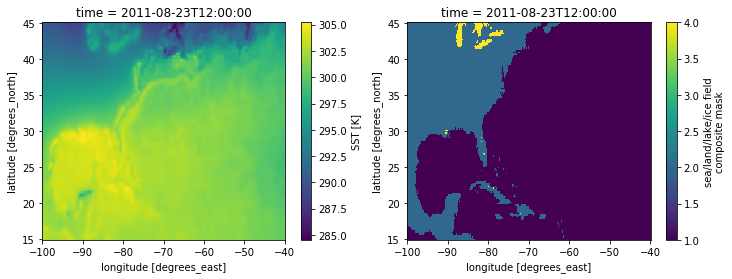

In [7]:
fig, axes = plt.subplots(ncols=2,figsize=[12,4])

subset_sst.analysed_sst.plot(ax=axes[0])

subset_sst.mask.plot(ax=axes[1])

## Mask out land values using .where

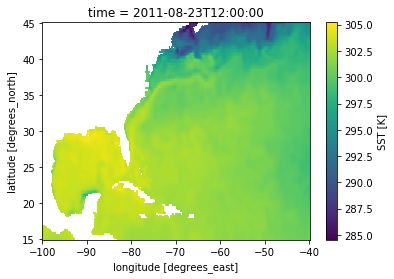

In [8]:
subset_sst_masked = subset_sst.where(subset_sst.mask==1)
subset_sst_masked.analysed_sst.plot()

## Compare time series of the cold wake after Hurricane as measured by MUR and OSTIA SSTs

## When you open a multi-file dataset, xarray uses dask for lasy loading.  
* Lazy loading: It mostly just loads the metadata. You can do data searching, selecting, subsetting without acutally loading the data. 
* Here we have loaded in 30 days of data for two very high resolution SST global datasets.  Before we actually load the data, we are going to want to do some subsetting so that it will fit into our memory.
* Notice below when you print out the dataset details that they are all stored as dask.array types.

In [9]:
ds_sst = xr.open_mfdataset(urls_mur,coords='minimal')
ds_sstlo = xr.open_mfdataset(urls_ostia,coords='minimal')
ds_sstlo['time'] = ds_sstlo.indexes['time'].to_datetimeindex()
ds_sst = subset_sst.where(ds_sst.mask==1)


In [ ]:
#subset data
subset_sst = ds_sst.sel(lat=slice(15,45),lon=slice(-100,-40))
subset_sstlo = ds_sstlo.sel(lat=slice(15,45),lon=slice(-100,-40))

In [ ]:
subset_sst.load()
subset_sstlo.load()

In [ ]:

subset_sst_interp_time = subset_sst.interp(time=subset_sstlo.time,
                                      method='linear')
subset_sst_interp = subset_sst_interp_time.interp(lat=subset_sstlo.lat,
                                      lon=subset_sstlo.lon,
                                      method='nearest')
# now use the sst mask on the wnd data
subset_sstlo_masked = subset_sstlo.where(subset_sst_interp.mask==1)



In [ ]:
fig, axes = plt.subplots(ncols=2,figsize=[12,4])

(subset_sst.analysed_sst[-1,:,:]-subset_sst.analysed_sst[0,:,:]).plot(vmin=-1,vmax=1,ax=axes[0])


(subset_sstlo_masked.analysed_sst[-1,:,:]-subset_sstlo_masked.analysed_sst[0,:,:]).plot(vmin=-1,vmax=1,ax=axes[0])



## Where can I find more info?

### For more information about xarray

- Read the [online documentation](http://xarray.pydata.org/)
- Ask questions on [StackOverflow](http://stackoverflow.com/questions/tagged/python-xarray)
- View the source code and file bug reports on [GitHub](http://github.com/pydata/xarray/)

### For more doing data analysis with Python:

- Thomas Wiecki, [A modern guide to getting started with Data Science and Python](http://twiecki.github.io/blog/2014/11/18/python-for-data-science/)
- Wes McKinney, [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do) (book)

### Packages building on xarray for the geophysical sciences

For analyzing GCM output:

- [xgcm](https://github.com/xgcm/xgcm) by Ryan Abernathey
- [oogcm](https://github.com/lesommer/oocgcm) by Julien Le Sommer
- [MPAS xarray](https://github.com/pwolfram/mpas_xarray) by Phil Wolfram
- [marc_analysis](https://github.com/darothen/marc_analysis) by Daniel Rothenberg

Other tools:

- [windspharm](https://github.com/ajdawson/windspharm): wind spherical harmonics by Andrew Dawson
- [eofs](https://github.com/ajdawson/eofs): empirical orthogonal functions by Andrew Dawson
- [infinite-diff](https://github.com/spencerahill/infinite-diff) by Spencer Hill 
- [aospy](https://github.com/spencerahill/aospy) by Spencer Hill and Spencer Clark
- [regionmask](https://github.com/mathause/regionmask) by Mathias Hauser
- [salem](https://github.com/fmaussion/salem) by Fabien Maussion

Resources for teaching and learning xarray in geosciences:
- [Fabien's teaching repo](https://github.com/fmaussion/teaching): courses that combine teaching climatology and xarray
